# Задача: Анализ эффективности нового алгоритма рекомендаций в условиях асимметричного и зашумленного распределения
### Контекст:
Крупная стриминговая платформа (аналог YouTube или Twitch) разработала новый алгоритм рекомендаций контента (алгоритм B), который, как ожидается, должен увеличить среднее время просмотра на пользователя по сравнению со старым алгоритмом (A).

Было проведено A/B-тестирование:

- **Группа A (Контрольная)**: 5000 пользователей, старый алгоритм.

- **Группа B (Тестовая)**: 5000 пользователей, новый алгоритм.

По итогам двухнедельного теста вы собрали данные по ключевой метрике — **«Общее время просмотра на пользователя за тест (в минутах)»**.

**Данные и их особенности:**

**Не нормальность:** Распределение метрики в обеих группах сильно отличается от нормального. Оно имеет типичный для поведенческих данных "длинный хвост":

- Большинство пользователей смотрят немного (пик в районе 0-50 минут).

- Небольшая группа "супер-зрителей" смотрит очень много (сотни и тысячи минут), формируя длинный правый хвост распределения.

**Асимметрия влияния:** Новый алгоритм B целенаправленно меняет опыт именно активных пользователей, в то время как для "пассивных" зрителей разница неочевидна. Это означает, что различие между группами может быть не сдвигом всего распределения, а изменением в правом хвосте.

**Наличие выбросов:** В данных присутствуют экстремальные выбросы (например, пользователи, которые оставляли видео фоном на всю ночь).

Вам предоставлен датасет _ab_test_results.csv_ со следующими колонками:

 - _user_id_

 - _group (A или B)_

 - _total_watch_time_min_

 ### Задания:
- **Проведите тест Манна-Уитни (Mann-Whitney U test)**. Сформулируйте нулевую и альтернативную гипотезы. Интерпретируйте p-value. Можно ли на его основе сделать однозначный вывод о превосходстве алгоритма B?

- Чтобы исследовать "асимметричное влияние", проведите анализ разниц не только в центре распределения, но и в хвостах. **Рассчитайте и визуализируйте разницу между группами для 75-го, 90-го и 95-го процентилей**.

- **Сформулируйте итоговый вывод:**

    - Эффективен ли новый алгоритм B?

    - На какую именно группу пользователей он оказывает наибольшее влияние?

    - Какой метод анализа оказался наиболее информативным в данном случае и почему?

    - Дайте рекомендацию о возможности запуска алгоритма на всю аудиторию.

# Решение

In [ ]:
# Импортируем все необходимые для работы библиотеки

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import skew, kurtosis

#### **Визуализация распределения**
Убедимся в том, что данные действительно не соответствуют нормальному распределению, есть асимметрия и выбросы. Для этого для обеих выборок:
- построим гистограмму распределения и boxplot
- рассчитаем skewness, kurtosis, медиану и среднее значение

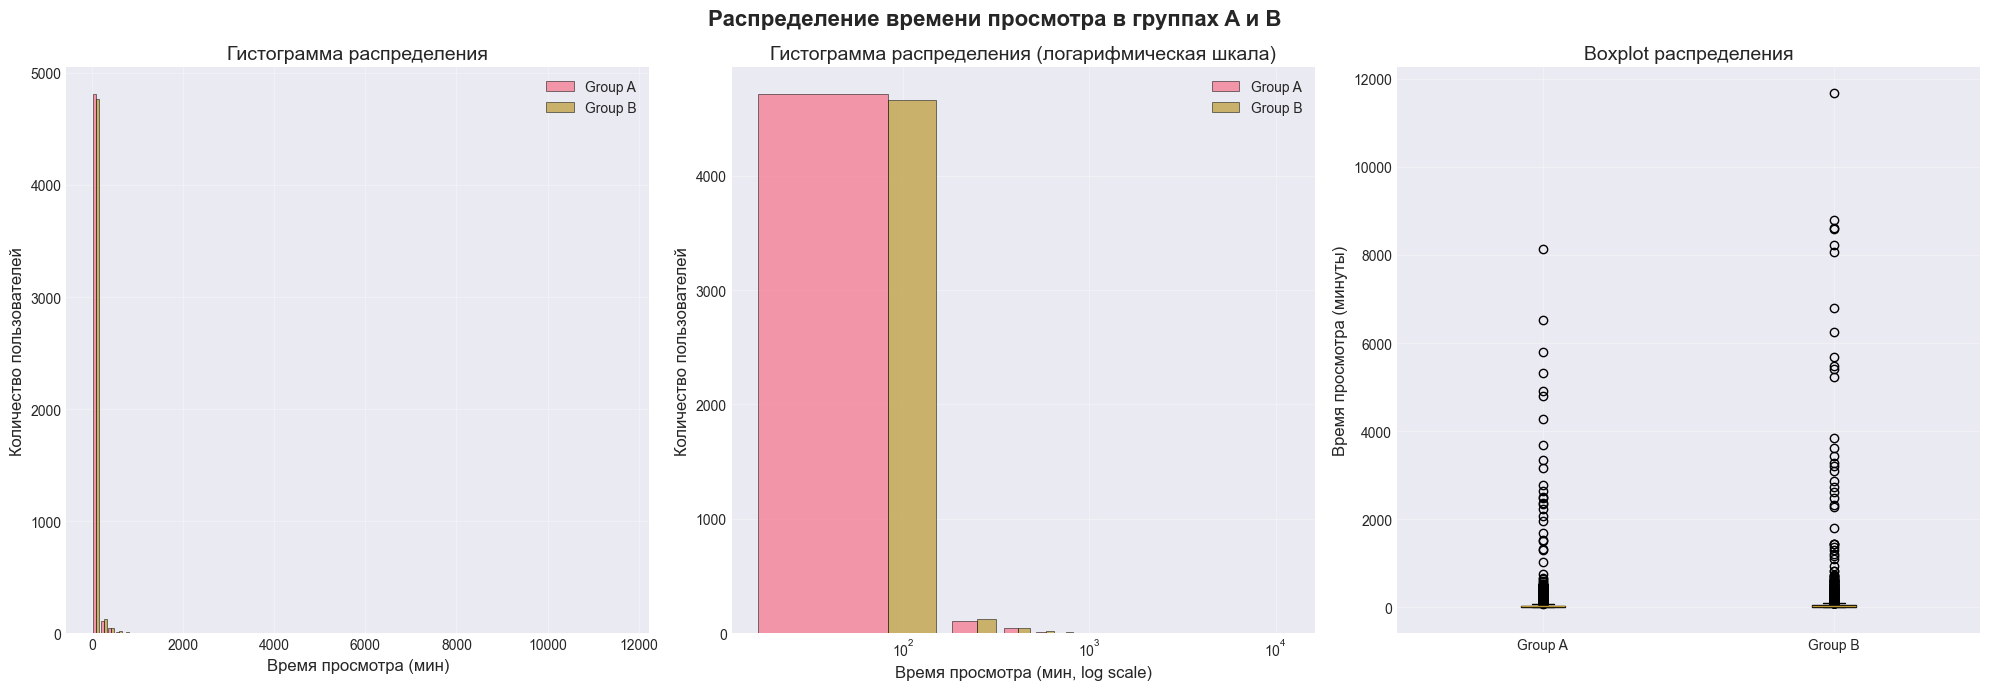


Коэффициент асимметрии (skewness):
Group A: 18.6077 (сильная правосторонняя асимметрия)
Group B: 17.6853 (сильная правосторонняя асимметрия)

Коэффициент эксцесса (kurtosis):
Group A: 416.4622 (очень тяжелые хвосты)
Group B: 362.1319 (очень тяжелые хвосты)

Сравнение медианы и среднего:
Group A: Медиана = 26.83, Среднее = 56.35
Group B: Медиана = 27.35, Среднее = 71.48


In [6]:
# Загрузим файл с данными, определим группы A и B
df = pd.read_csv('C:/Users/U_M1P8G/Desktop/IDE/ab_course/ab_test_results.csv')

group_a_data = df[df['group'] == 'A']['total_watch_time_min']
group_b_data = df[df['group'] == 'B']['total_watch_time_min']

# ВИЗУАЛИЗАЦИЯ

# Настроим стиль графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Создадим фигуру с несколькими subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle('Распределение времени просмотра в группах A и B', fontsize=16, fontweight='bold')

# 1. Гистограмма
axes[0].hist([group_a_data, group_b_data], 
                bins=70, 
                alpha=0.7, 
                label=['Group A', 'Group B'],
                edgecolor='black',
                linewidth=0.5)
axes[0].set_xlabel('Время просмотра (мин)', fontsize=12)
axes[0].set_ylabel('Количество пользователей', fontsize=12)
axes[0].set_title('Гистограмма распределения', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Гистограмма с логарифмической шкалой по оси X
axes[1].hist([group_a_data[group_a_data > 0], group_b_data[group_b_data > 0]], 
                bins=70, 
                alpha=0.7, 
                label=['Group A', 'Group B'],
                edgecolor='black',
                linewidth=0.5)
axes[1].set_xlabel('Время просмотра (мин, log scale)', fontsize=12)
axes[1].set_ylabel('Количество пользователей', fontsize=12)
axes[1].set_title('Гистограмма распределения (логарифмическая шкала)', fontsize=14)
axes[1].set_xscale('log')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Boxplot для визуализации выбросов и квартилей
boxplot_data = [group_a_data, group_b_data]
box = axes[2].boxplot(boxplot_data, 
                         patch_artist=True,
                         showfliers=True,  # Показываем выбросы
                         whis=1.5)  # По умолчанию 1.5 * IQR
axes[2].set_xticks([1, 2])
axes[2].set_xticklabels(['Group A', 'Group B'])

# Раскрасим боксы
colors = ['lightblue', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

axes[2].set_ylabel('Время просмотра (минуты)', fontsize=12)
axes[2].set_title('Boxplot распределения', fontsize=14)
axes[2].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

# Дополнительная статистика для анализа асимметрии

skew_a = skew(group_a_data)
skew_b = skew(group_b_data)
kurt_a = kurtosis(group_a_data)
kurt_b = kurtosis(group_b_data)

print(f"\nКоэффициент асимметрии (skewness):")
print(f"Group A: {skew_a:.4f} (сильная правосторонняя асимметрия)")
print(f"Group B: {skew_b:.4f} (сильная правосторонняя асимметрия)")

print(f"\nКоэффициент эксцесса (kurtosis):")
print(f"Group A: {kurt_a:.4f} (очень тяжелые хвосты)")
print(f"Group B: {kurt_b:.4f} (очень тяжелые хвосты)")

# Медиана vs Среднее
print(f"\nСравнение медианы и среднего:")
print(f"Group A: Медиана = {np.median(group_a_data):.2f}, Среднее = {np.mean(group_a_data):.2f}")
print(f"Group B: Медиана = {np.median(group_b_data):.2f}, Среднее = {np.mean(group_b_data):.2f}")



#### **Выводы**: 
У обеих групп распределение действительно отличается от нормального.
По графикам видно, что:
1. Форма распределения не похожа на "колокол" - резкий пик слева и длинный хвост справа.
2. Правая часть гистограммы сильно растянута по сравнению с левой - есть асимметрия
3. на Boxplot визуализируется большое кол-во "выбросов" - множество точек выше верхнего "уса"
4. Медиана не в центре 

Статистики для анализа асимметрии также показывают асимметрию в обеих группах:
1. Skewness положительный и более 10, что говорит об экстремальной правосторонней асимметрии
2. kurtosis: положительный для обеих выборок и экстремально высокий (для нормального распределения в текущем расчете scipy он должен быть около нуля) - сильная тяжесть хвостов, отличие от нормального распределения
3. В обеих группах медиана даже приближенно не равна среднему значению. Среднее больше медины более чем в 2 раза, что говорит о:
- не нормальности данных (при нормальном распределении среднее значение равно или хотя бы приблизительно равно медиане)
- правой асимметрии: среднее больше медианы за счет небольшой группы "супер-зрителей"


## **Тест Манна-Уитни (Mann-Whitney U test)**. 
1. Сформулируем нулевую и альтернативную гипотезы. 

В задаче представлен двусторонний тест, это значит, что мы смотрим отличия между А и B в обе стороны. Таким образом:

Нулевая гипотеза **H0**: Распределение общего время просмотра на пользователя в обеих группах одинаково. Влияние нового алгоритма на данную метрику отсутствует.
    
Альтернативная гипотеза **H1**: Распределение общего времени просмотра на пользователя в обеих группах отличается. Есть влияние нового алгоритма на данную метрику.

Т.к. тест двусторонний, в формулировке H1 не уточняем, в какую сторону (большую или меньшую) есть влияние


2. Проведем тест:

In [8]:
# Display summary statistics
print("Dataset Summary:")
print(f"Total users: {len(df)}")
print(f"Group A: {len(df[df['group'] == 'A'])} users")
print(f"Group B: {len(df[df['group'] == 'B'])} users")
print("\nDescriptive Statistics by Group:")
print(df.groupby('group')['total_watch_time_min'].describe())

print("\nKey Percentiles by Group:")
percentiles = [0.75, 0.9, 0.95]
for p in percentiles:
    p_val = p * 100
    a_val = np.percentile(group_a_data, p_val)
    b_val = np.percentile(group_b_data, p_val)
    diff = b_val - a_val
    print(f"{p_val:.0f}th percentile: A={a_val:.1f}, B={b_val:.1f}, Difference={diff:.1f}")

# Test the differences
from scipy import stats
mw_stat, mw_p = stats.mannwhitneyu(
    group_a_data,
    group_b_data,
    alternative= 'two-sided' #'less' #'greater' #'two-sided'
)

print(f"\nMann-Whitney U Test: p-value = {mw_p:.6f}")

Dataset Summary:
Total users: 10000
Group A: 5000 users
Group B: 5000 users

Descriptive Statistics by Group:
        count       mean         std  min        25%        50%        75%  \
group                                                                        
A      5000.0  56.347878  262.313288  0.0  14.729144  26.834960  44.946309   
B      5000.0  71.477408  408.519252  0.0  15.383838  27.352416  46.352279   

                max  
group                
A       8130.547119  
B      11670.621483  

Key Percentiles by Group:
75th percentile: A=44.9, B=46.4, Difference=1.4
90th percentile: A=71.5, B=76.2, Difference=4.7
95th percentile: A=119.3, B=153.6, Difference=34.3

Mann-Whitney U Test: p-value = 0.045342


#### Интерпретируем **p-value**

p-value = 0.0453, что меньше общепринятого альфа (0.05), но принимает близкое к пограничному значение. Это говорит о статистически значимых различиях между распределениями общего времени просмотра на пользователя в группах A и B при альфа = 0.05, но при более жестких требованиях к тесту (к примеру, при альфа менее 4%), гипотеза H0 не будет отвергнута.

Только на основании p-value  нельзя сделать однозначный вывод о превосходстве алгоритма B над A, т.к.:
1. Мы провели двусторонний тест, это значит, что p-value в целом говорит о наличии стат. значимых различий в распределении значения метрики между группами, но не свидетельствует о направлении этого различия (не отвечает на вопрос "что лучше - A или B")

2. Согласно условию задачи, новый алгоритм B целенаправленно меняет опыт именно активных пользователей, в то время как для "пассивных" зрителей разница неочевидна. Это означает, что различие между группами может быть не сдвигом всего распределения, а изменением в правом хвосте.
Только по значению p-value мы не можем оценить, в какой части распределения произошли изменения. Действительно ли "как задумано" новый алгоритм работает на более активных пользователей или нет. Для этого требуется дополнительный анализ асимметрии влияния.

В коде выше проведен такой анализ. Его результат явно указывает на асимметрию влияния - разница в метрике в 95 перцентиле значительно выше, чем в 75%. На 50-м перцентиле разница между группой А и B минимальна 



## **Анализ "ассиметричного влияния"**

Разница между группами А и В в разных перцентилях была рассчитана ранее. Дополним расчет 99 перцентилем, визуализируем разницу и сделаем выводы.

Анализ перцентилей

  Percentile  Group_A  Group_B  Difference_B_A  Relative_Diff_%
0       25th    14.73    15.38            0.65             4.44
1       50th    26.83    27.35            0.52             1.93
2       75th    44.95    46.35            1.41             3.13
3       90th    71.52    76.24            4.72             6.60
4       95th   119.34   153.62           34.28            28.72
5       99th   435.58   585.91          150.33            34.51


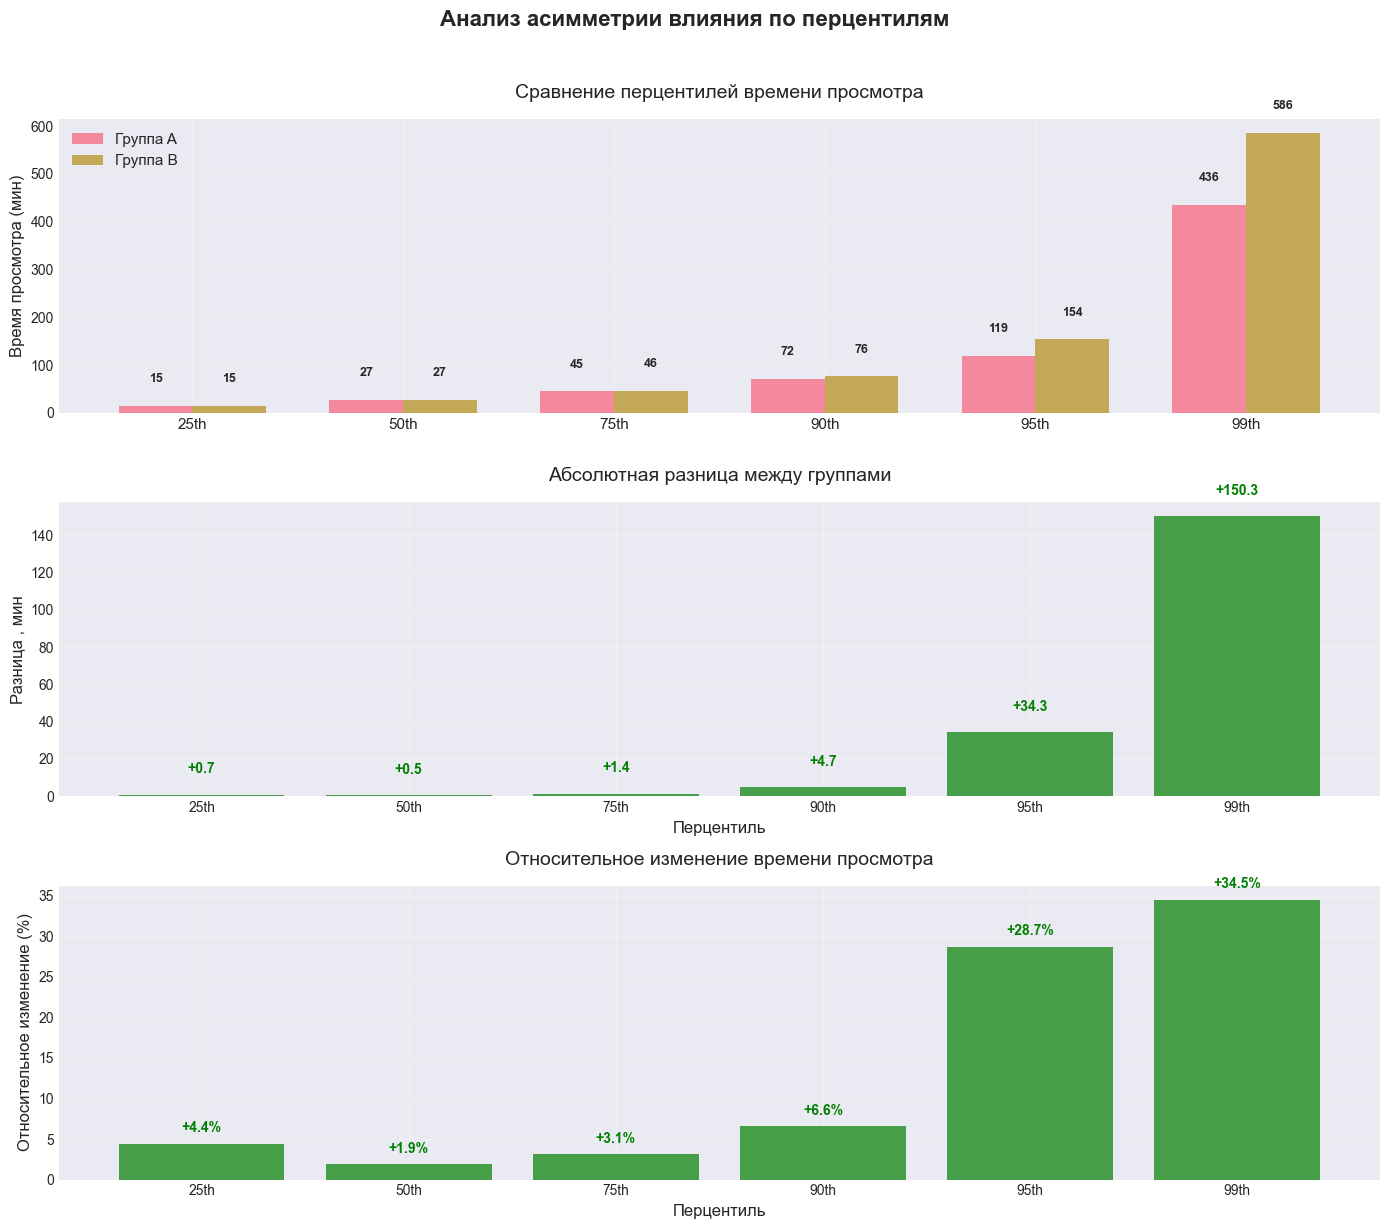

Статистические анализ 'хвостов' распределения

1. Анализ 'тяжелых' пользователей (верхние 5%):

95-й перцентиль (порог):
  Группа A: 119.3 мин
  Группа B: 153.6 мин

Характеристики 'тяжелых' пользователей:
  Количество пользователей: A = 250, B = 250
  Среднее время: A = 556.1 мин, B = 828.3 мин
  Разница средних: 272.2 мин
  Относительное изменение: +49.0%

  Односторонний Mann-Whitney U test для 'тяжелых' пользователей:
  p-value = 0.000001


2. Анализ 'легких' пользователей (нижние 50%):

50-й перцентиль (порог):
  Группа A: 26.8 мин
  Группа B: 27.4 мин

Характеристики 'легких' пользователей:
  Количество пользователей: A = 2500, B = 2500
  Среднее время: A = 14.2 мин, B = 14.8 мин
  Разница средних: 0.6 мин
  Относительное изменение: +4.2%

  Односторонний Mann-Whitney U test для 'легких' пользователей:
  p-value = 0.001978


In [40]:
# Настройки визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 1. Анализ перцентилей
# в условии задачи требуется анализ 75, 90 и 95 перцентилей, 
# но мы дополнительно для наглядности и полноты анализа возьмем 25, 50 и 99 перцентили

percentiles = [25, 50, 75, 90, 95, 99]
percentile_values = [0.25, 0.50, 0.75, 0.90, 0.95, 0.99]  # Для функции percentile
percentile_labels = [f'{p}th' for p in percentiles]

# Расчет перцентилей для каждой группы
a_percentiles = np.percentile(group_a_data, [p*100 for p in percentile_values])
b_percentiles = np.percentile(group_b_data, [p*100 for p in percentile_values])
percentile_diffs = b_percentiles - a_percentiles

# Создание DataFrame для результатов
percentile_df = pd.DataFrame({
    'Percentile': percentile_labels,
    'Group_A': a_percentiles,
    'Group_B': b_percentiles,
    'Difference_B_A': percentile_diffs,
    'Relative_Diff_%': (percentile_diffs / a_percentiles * 100)
})

print("Анализ перцентилей\n")
print(percentile_df.round(2))

# 2. Визуализация
fig, axes = plt.subplots(3, 1, figsize=(14, 12))  # Увеличим высоту
fig.suptitle('Анализ асимметрии влияния по перцентилям', fontsize=16, fontweight='bold', y=1.02)

# График 1: Barplot перцентилей
ax1 = axes[0]
x_pos = np.arange(len(percentile_labels))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, a_percentiles, width, label='Группа A', alpha=0.8)
bars2 = ax1.bar(x_pos + width/2, b_percentiles, width, label='Группа B', alpha=0.8)

ax1.set_ylabel('Время просмотра (мин)', fontsize=12)
ax1.set_title('Сравнение перцентилей времени просмотра', fontsize=14, pad=15)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(percentile_labels, fontsize=11)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Добавление значений над барами
for i, (a_val, b_val) in enumerate(zip(a_percentiles, b_percentiles)):
    ax1.text(i - width/2, a_val + 50, f'{a_val:.0f}', ha='center', fontsize=9, fontweight='bold')
    ax1.text(i + width/2, b_val + 50, f'{b_val:.0f}', ha='center', fontsize=9, fontweight='bold')

# График 2: Абсолютная разница
ax2 = axes[1]
colors = ['green' if x > 0 else 'red' for x in percentile_diffs]
bars_diff = ax2.bar(percentile_labels, percentile_diffs, color=colors, alpha=0.7)

ax2.set_xlabel('Перцентиль', fontsize=12)
ax2.set_ylabel('Разница , мин', fontsize=12)
ax2.set_title('Абсолютная разница между группами', fontsize=14, pad=15)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.grid(True, alpha=0.3)

# Добавление значений разницы
for i, diff in enumerate(percentile_diffs):
    offset = 10 if diff > 0 else -15
    va = 'bottom' if diff > 0 else 'top'
    ax2.text(i, diff + offset, f'+{diff:.1f}' if diff > 0 else f'{diff:.1f}', 
             ha='center', fontsize=10, fontweight='bold',
             color='green' if diff > 0 else 'red', va=va)

# График 3: Относительное изменение
ax3 = axes[2]
relative_change = (percentile_diffs / a_percentiles) * 100
colors_rel = ['green' if x > 0 else 'red' for x in relative_change]
bars_rel = ax3.bar(percentile_labels, relative_change, color=colors_rel, alpha=0.7)

ax3.set_xlabel('Перцентиль', fontsize=12)
ax3.set_ylabel('Относительное изменение (%)', fontsize=12)
ax3.set_title('Относительное изменение времени просмотра', fontsize=14, pad=15)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.grid(True, alpha=0.3)

# Добавление процентных значений
for i, rel in enumerate(relative_change):
    offset = 1 if rel > 0 else -2
    va = 'bottom' if rel > 0 else 'top'
    ax3.text(i, rel + offset, f'+{rel:.1f}%' if rel > 0 else f'{rel:.1f}%', 
             ha='center', fontsize=10, fontweight='bold',
             color='green' if rel > 0 else 'red', va=va)

plt.tight_layout()
plt.show()

# 3. Статистический анализ "хвостов" распределения

print("Статистические анализ 'хвостов' распределения")

# 3.1 Верхние 5% ("тяжелые пользователи")
print("\n1. Анализ 'тяжелых' пользователей (верхние 5%):\n")

heavy_user_threshold_a = np.percentile(group_a_data, 95)  # 95-й перцентиль
heavy_user_threshold_b = np.percentile(group_b_data, 95)

heavy_users_a = group_a_data[group_a_data >= heavy_user_threshold_a]
heavy_users_b = group_b_data[group_b_data >= heavy_user_threshold_b]

print(f"95-й перцентиль (порог):")
print(f"  Группа A: {heavy_user_threshold_a:.1f} мин")
print(f"  Группа B: {heavy_user_threshold_b:.1f} мин")

print(f"\nХарактеристики 'тяжелых' пользователей:")
print(f"  Количество пользователей: A = {len(heavy_users_a)}, B = {len(heavy_users_b)}")
print(f"  Среднее время: A = {heavy_users_a.mean():.1f} мин, B = {heavy_users_b.mean():.1f} мин")
print(f"  Разница средних: {heavy_users_b.mean() - heavy_users_a.mean():.1f} мин")
print(f"  Относительное изменение: {(heavy_users_b.mean()/heavy_users_a.mean()-1)*100:+.1f}%")

# Тест Манна-Уитни для тяжелых пользователей (односторонний, B>A)
mw_heavy_stat, mw_heavy_p = stats.mannwhitneyu(
    heavy_users_b,
    heavy_users_a,  
    alternative='greater'
)
print(f"\n  Односторонний Mann-Whitney U test для 'тяжелых' пользователей:")
print(f"  p-value = {mw_heavy_p:.6f}")

# 3.2 Легкие пользователи (нижние 50%)
print("\n\n2. Анализ 'легких' пользователей (нижние 50%):\n")

light_user_threshold_a = np.percentile(group_a_data, 50) 
light_user_threshold_b = np.percentile(group_b_data, 50)

light_users_a = group_a_data[group_a_data <= light_user_threshold_a]  # <= для нижних 50%
light_users_b = group_b_data[group_b_data <= light_user_threshold_b]

print(f"50-й перцентиль (порог):")
print(f"  Группа A: {light_user_threshold_a:.1f} мин")
print(f"  Группа B: {light_user_threshold_b:.1f} мин")

print(f"\nХарактеристики 'легких' пользователей:")
print(f"  Количество пользователей: A = {len(light_users_a)}, B = {len(light_users_b)}")
print(f"  Среднее время: A = {light_users_a.mean():.1f} мин, B = {light_users_b.mean():.1f} мин")
print(f"  Разница средних: {light_users_b.mean() - light_users_a.mean():.1f} мин")
print(f"  Относительное изменение: {(light_users_b.mean()/light_users_a.mean()-1)*100:+.1f}%")

# Односторонний Тест Манна-Уитни для легких пользователей (B>A)
mw_light_stat, mw_light_p = stats.mannwhitneyu(
    light_users_b,
    light_users_a, 
    alternative='greater'
)
print(f"\n  Односторонний Mann-Whitney U test для 'легких' пользователей:")
print(f"  p-value = {mw_light_p:.6f}")





### **Выводы** по анализу "асимметричного" влияния:

1. Статистическая значимость различий наблюдается во всех перцентилях, но практическая значимость только начиная с 90-95 перцентиля:

    - Среднее время просмотра в 50-м перцентиле возросло всего на 0,6 мин. Статистически значимо (p-value одностороннего Mann-Whitney U test всего 0.002), но практически не значимо.
    - Среднее время просмотра в 95-м перцентиле возросло более чем на 270 минут (почти в 1,5 раза) -значимо и статистически (p-value = 0.000001), и практически.

    При высокой чувствительности экономического эффекта от длительности просмотра, практически значимым результатом можно считать эффект в 90-м перцентиле (наблюдаем рост порога на 4.7 мин.)
2. Как и ожидалось, новый алгоритм работает только для активных пользователей, значимо (статистически и практически) увеличивая их общее время просмотра на пользователя. 


In [43]:
# Интересно посмотреть на двусторонний p-value для разных перцентилей
# и сравнить с общим p-value, по всей выборке, полученном ранее (0.045) 
percentiles = [25, 50, 75, 90, 95, 99]

print("Percentile | p-value (two-sided)")
print("-" * 35)

for p in percentiles:
    # Выбираем пользователей выше p-перцентиля
    users_a = group_a_data[group_a_data >= np.percentile(group_a_data, p)]
    users_b = group_b_data[group_b_data >= np.percentile(group_b_data, p)]
    
    # Тест Манна-Уитни
    _, p_val = stats.mannwhitneyu(users_a, users_b, alternative='two-sided')
    
    print(f"{p:>4}th     | {p_val:.6f}")
    
# Дополнительно посмотрим на дисперсию  на разных участках распределения 

q25_a, q75_a = np.percentile(group_a_data, [25, 75])
q25_b, q75_b = np.percentile(group_b_data, [25, 75])

results = {
    'tail': {
        'var_a': np.var(group_a_data[group_a_data >= np.percentile(group_a_data, 95)]),
        'var_b': np.var(group_b_data[group_b_data >= np.percentile(group_b_data, 95)])
    },
    'tail_99': {
        'var_a': np.var(group_a_data[group_a_data >= np.percentile(group_a_data, 99)]),
        'var_b': np.var(group_b_data[group_b_data >= np.percentile(group_b_data, 99)])
    },
    'center': {
        'var_a': np.var(group_a_data[(group_a_data >= q25_a) & (group_a_data <= q75_a)]),
        'var_b': np.var(group_b_data[(group_b_data >= q25_b) & (group_b_data <= q75_b)])
    },
    'left_part': {
        'var_a': np.var(group_a_data[group_a_data < q25_a]),
        'var_b': np.var(group_b_data[group_b_data < q25_b])
         },
    'all': {
        'var_a': np.var(group_a_data),
        'var_b': np.var(group_b_data)
    }
}

print ('\nСравнение дисперсий\n')

for key, vals in results.items():
    ratio = vals['var_b'] / vals['var_a']
    print(f"{key:10} | A: {vals['var_a']:8.0f} | B: {vals['var_b']:8.0f} | B/A: {ratio:.1f}x")  

Percentile | p-value (two-sided)
-----------------------------------
  25th     | 0.010978
  50th     | 0.005829
  75th     | 0.000258
  90th     | 0.000003
  95th     | 0.000002
  99th     | 0.002182

Сравнение дисперсий

tail       | A:  1104209 | B:  2723100 | B/A: 2.5x
tail_99    | A:  3387937 | B:  7822564 | B/A: 2.3x
center     | A:       72 | B:       74 | B/A: 1.0x
left_part  | A:       19 | B:       21 | B/A: 1.1x
all        | A:    68794 | B:   166855 | B/A: 2.4x


1. Мы видим, что стат. значимость растет с увеличением перцентиля (кроме 99 - возможно, здесь причина в малом кол-ве пользователей, высокой дисперсии, возможными "выбросами")
2. Интересно то, что p-value отдельно частей распределения выше, чем общий по всей выборке (0.045). Причины такой картины- разная дисперсия и смешение разнородных эффектов: в левой части распределения и в центре дисперсии почти равны. При этом в правой части и в целом по всей выборке дисперсия группы B более чем в 2 раза больше дисперсии A.

В итоге тест сталкивается с противоречивыми свидетельствами:
- Хвост: B явно больше A, B более разбросана, чем А
- Центр: B чуть больше A, B примерно так же разбросана, как и A
- Из всей выборки: B больше А, B более разбросана, чем A
Из-за таких противоречивых сигналов тест дал пограничный результат по всей выборке (p-value = 0.045). Но разница в правом хвосте настолько сильна, что тест все-таки эту разницу заметил и посчитал стат. значимой.




# **Итоговые выводы и ответы на вопросы**

#### 1. **Тест Манна-Уитни (Mann-Whitney U test)**. 
Сформулируйте нулевую и альтернативную гипотезы. Интерпретируйте p-value. Можно ли на его основе сделать однозначный вывод о превосходстве алгоритма B?

##### **Ответ**:
Детально выводы и рассуждения были представлены выше. Здесь приведем основные тезисы:
1.1. Гипотезы по двустороннему тесту Манна-Уитни: 
**H0** — распределения времени просмотра на пользователя одинаковы 
**H1** — распределения различаются. 

1.2. p-value = 0.045 свидетельствует о статистически значимых различиях при α = 0.05, однако его пограничное значение требует осторожности в интерпретации.

Однозначно судить о превосходстве алгоритма B по этому p-value ***нельзя***, так как:
- двусторонний тест не указывает направление эффекта
- p-value не раскрывает асимметричное влияние алгоритма на разные группы пользователей, которое могло сконцентрироваться в правом хвосте распределения.

#### **2. Эффективен ли новый алгоритм B?**

##### **Ответ**:
Согласно условию задачи, новый алгоритм ***целенаправленно*** работает именно с активными пользователями. При такой постановке задачи можно сказать, что да, алгоритм эффективен. Т.е. он делает активных пользователей еще более активными.

Если бы целью алгоритма было в целом увеличение роста времени просмотра по всем группам пользователей, или активизация неактивных пользователей, то выводы об эффективности нового алгоритма были бы не столь однозначны.

#### **3. На какую именно группу пользователей он оказывает наибольшее влияние?**

##### **Ответ**:
На группу активных пользователей, находящихся в правом хвосте (самый высокий эффект в 95-м перцентиле)

#### **4. Какой метод анализа оказался наиболее информативным в данном случае и почему?**

##### **Ответ**:
Наиболее информативным оказался метод анализа "асимметричного" влияния, когда мы исследовали разницу в разных перцентилях. Изначально двусторонний тест Манна-Уитни не выявил, в какую сторону есть стат. значимые различия, и на какую группу пользователей влияет алгоритм.

#### **5. Дайте рекомендацию о возможности запуска алгоритма на всю аудиторию.**

##### **Ответ**:
Рекомендации: запустить новый алгоритм в случае, если:
- экономический эффект оправдан, т.е. потенциальный доход превышает расходы на новый алгоритм (требуется доп. анализ экономического эффекта)
- если нет потенциальных рисков ухудшения клиентского опыта для неактивных пользователей
- желательно убедиться в том, что в правом хвосте экстремально высокие значения - это просто "фоновое" прослушивание (когда, к примеру, пользователь, на ночь включает видео и фактически не смотрит его), а действительно активное использование платформы